<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Torch源代码基础链路" data-toc-modified-id="Torch源代码基础链路-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Torch源代码基础链路</a></span><ul class="toc-item"><li><span><a href="#源代码结构" data-toc-modified-id="源代码结构-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>源代码结构</a></span></li><li><span><a href="#实现链路：以Tensor.dtype为例" data-toc-modified-id="实现链路：以Tensor.dtype为例-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>实现链路：以Tensor.dtype为例</a></span></li><li><span><a href="#实现链路：以torch.add为例" data-toc-modified-id="实现链路：以torch.add为例-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>实现链路：以torch.add为例</a></span></li></ul></li></ul></div>

In [1]:
import torch

> 使用的是torch 1.13.1版本

# Torch源代码基础链路

pytorch的底层实现其实是基于C/C++的，平常我们大多使用其提供的python接口编写模型训练和推理代码（pip安装torch包），或者有时候直接使用其C++接口（libtorch.so）。torch中的Tensor、device、自动求导等功能都在底层实现。

## 源代码结构

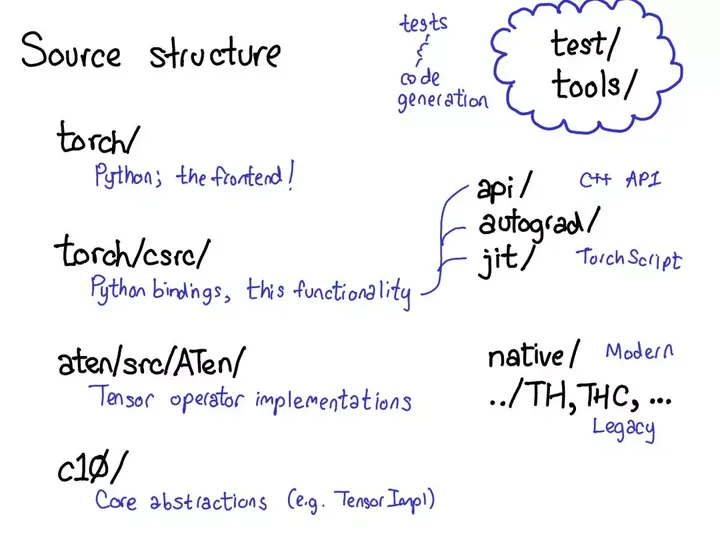

torch的源代码中最重要的几个部分：
+ torch: 平常使用时看到的torch接口、类和函数等
+ torch/csrc: pybinding相关代码，绑定了pytorch接口和C++实现，包括api、jit和autograd等。api是C++提供的接口；jit则对应TorchScript，是pytorch提供的静态图实现方式；autograd则是自动求导相关功能，用于模型训练时loss的反向求导。
+ aten/src/ATen: A Tesor Library, C++实现的张量计算库，我们在torch前端用到的很多计算函数或者说算子，其实绝大部分在底层都是用aten实现的。
+ C10: torch完整的集成了caffe框架的后端，用于实现基本的Tensor操作，在ATen中会看到大量使用了C10中的功能。
+ tools：除了上述几部分之外，另一个很重的目录是tools。这个目录里面有大量生成.pyi存根文件的代码和绑定python接口和C++接口的自动功能。

## 实现链路：以Tensor.dtype为例

下面以Tensor.dtype为例来说明torch的整个实现链路。下面的代码随机初始化了一个Tensor变量a，并且打印了其类型，那么在这后面到底调用了哪些代码？

In [4]:
a = torch.Tensor()
a.dtype

torch.float32

首先，调用`torch.Tensor()`返回的a是`torch.Tensor`类型，那么先来看类`Tensor`的定义。根据python的机制，当我们调用`torch.Tensor()`时，其实是从`torch/__init__.py`中找`Tensor`。从下面的导入代码中可以看到`Tensor`的定义在`_tensor.py`文件中。

```python
# torch/__init__/py
from ._tensor import Tensor

# torch/_tensor.py
class Tensor(torch._C._TensorBase)
```

根据`Tensor`的定义可以发现它继承了类`torch._C._TensorBase`。那么现在就遇到了torch中一个很重要`_C`模块。在解释这个模块之前，需要介绍一下pybind11。简单来说，当我们希望在python中调用使用C++编写的函数时，可以通过pybind11定义C++对应的python模块和函数，从而在python实现import模块并调用相应函数。同样的，torch中python接口和C++接口的绑定也是由pybind11完成，而`_C`就是C++动态库对应的python模块名称。

```C++
// torch/csrc/Module.cpp
static struct PyModuleDef torchmodule = {
    PyModuleDef_HEAD_INIT, "torch._C", nullptr, -1, methods.data()};
ASSERT_TRUE(module = PyModule_Create(&torchmodule));
```

那么显然，类`torch._C._TensorBase`接口必然对应了某个C++中的接口，我们可以在`_TensorBase`的定义文件中找到：
```python
# torch/_C/__init__.pyi.in

# Defined in torch/csrc/autograd/python_variable.cpp
class _TensorBase(metaclass=_TensorMeta):   
    ...
```

```C++
// torch/csrc/autograd/python_variable.cpp
PyModule_AddObject(module, "_TensorBase", (PyObject*)&THPVariableType);
```

从pybind11的定义中得知`_TensorBase`对应了C++中的`THPVariableType`：
```C++
# torch/csrc/autograd/python_variable.cpp
PyTypeObject THPVariableType = {
    PyVarObject_HEAD_INIT(
        &THPVariableMetaType,
        0) "torch._C._TensorBase", /* tp_name */
    sizeof(THPVariable), /* tp_basicsize */
    0, /* tp_itemsize */
    ......
    THPVariable_properties, /* tp_getset */
    ......
    THPVariable_pynew, /* tp_new */
};
```

而从`THPVariableType`的定义中并没有找到dtype这个函数或者属性，其实它是定义在结构体`THPVariable_properties`中，这个结构体包含了Tensor的相关属性，比如dtype、ndims、shape等。

```C++
static struct PyGetSetDef THPVariable_properties[] = {
    {"_python_dispatch",
    ......
    {"requires_grad",
     (getter)THPVariable_get_requires_grad,
     (setter)THPVariable_set_requires_grad,
     nullptr,
     nullptr},
    {"shape", (getter)THPVariable_get_shape, nullptr, nullptr, nullptr},
    {"dtype", (getter)THPVariable_dtype, nullptr, nullptr, nullptr},
    {"device", (getter)THPVariable_device, nullptr, nullptr, nullptr},
    {"ndim", (getter)THPVariable_get_ndim, nullptr, nullptr, nullptr},
    ......
    };
```

进一步从结构体的定义中可以发现dtype对应`THPVariable_dtype`函数，这个函数输入的`THPVariable`是调用dtype的对象，最终调用`torch::getTHPDtype(self_.scalar_type())`获取类型。

```C++
static PyObject* THPVariable_dtype(THPVariable* self, void* unused) {
  HANDLE_TH_ERRORS
  if (check_has_torch_function((PyObject*)self)) {
    return handle_torch_function_getter(self, "dtype");
  }
  auto& self_ = THPVariable_Unpack(self);  # self_ -> Tensor
  return torch::autograd::utils::wrap(torch::getTHPDtype(self_.scalar_type()));
  END_HANDLE_TH_ERRORS
}
```

> 
> 这里稍微解释一下`check_has_torch_function`和`handle_torch_function_getter`在干嘛。平常当我们在使用a.dtype获取类型是，a可能是Tensor也可能是numpy::ndarray。如果是Tensor那么可以直接调用Tensor对应的函数，但是如果是ndarray要怎么办呢？torch就提供了一种类似“子类”的方式来支持，这个子类需要有`__torch__function__`属性来记录自己实现了什么对应的torch函数，从而可以使用handle_torch_function_getter获取对应的函数。
> + https://github.com/pytorch/pytorch/issues/22402
> + https://github.com/pytorch/pytorch/issues/24015

首先来看`scalar_type()`在干什么，这个函数获取的是`ScalarType`类型的结果。而`ScalarType`在C10中定义：
```C++
# c10/core/ScalarType.h
ScalarType // 根据设置不同定义不同
#define AT_FORALL_SCALAR_TYPES(_) \
  _(uint8_t, Byte)                \
  _(int8_t, Char)                 \
  _(int16_t, Short)               \
  _(int, Int)                     \
  _(int64_t, Long)                \
  _(float, Float)                 \
  _(double, Double)
```

在初始化的时候会注册所有的类型，将类型转换为我们更熟悉的float32、float16等类型：
```C++
# torch/csrc/DynamicTypes.cpp
void registerDtypeObject(THPDtype* dtype, at::ScalarType scalarType) {
  dtype_registry[static_cast<int>(scalarType)] = dtype;
}

# torch/csrc/utils/tensor_dtypes.cpp
void initializeDtypes() {
  auto torch_module = THPObjectPtr(PyImport_ImportModule("torch"));
  if (!torch_module)
    throw python_error();

  ......

  for (at::ScalarType scalarType : all_scalar_types) {
    std::string primary_name, legacy_name;
    std::tie(primary_name, legacy_name) = getDtypeNames(scalarType);
    PyObject* dtype = THPDtype_New(scalarType, primary_name);
    torch::registerDtypeObject((THPDtype*)dtype, scalarType);

  .......

  }
}


std::pair<std::string, std::string> getDtypeNames(at::ScalarType scalarType) {
	switch (scalarType) {
	  ......
	  case at::ScalarType::Float:
        return std::make_pair("float32", "float");
      ......
	}
}
```

在调用.dtype时从注册map中获取结果：
```C++
THPDtype* getTHPDtype(at::ScalarType scalarType) {
  auto dtype = dtype_registry[static_cast<int>(scalarType)];
  if (!dtype) {
    throw std::invalid_argument("unsupported scalarType");
  }
  return dtype;
}
```

## 实现链路：以torch.add为例

当我们在前端调用torch.add方法时，最终调用的是底层C++在ATen实现的Add算子，整个过程大致如下（使用1.13.1版本，不同版本实现有差异）：
+ 在python侧调用torch.add时会执行torch目录下的`__init__.py`文件，该文件中将从`_C/_VariableFunctions.pyi`文件中导入add函数。`_C/_VariableFunctions`里面包含了使用C++实现的函数。
```python
for name in dir(_C._VariableFunctions):
    if name.startswith('__') or name in PRIVATE_OPS:
        continue
    obj = getattr(_C._VariableFunctions, name)
    obj.__module__ = 'torch'
    # Hide some APIs that should not be public
    if name == "segment_reduce":
        # TODO: Once the undocumented FC window is passed, remove the line bellow
        globals()[name] = obj
        name = "_" + name
    globals()[name] = obj
    if not name.startswith("_"):
        __all__.append(name)
```

+ `_C._VaraibleFunctions`是由pybinding将python和C++进行绑定时定义的名称，其中`torch._C`表示整个C++模块，`_VaraibleFunctions`代表C++实现的函数：
``` python
# torch/csrc/Module.cpp
static struct PyModuleDef torchmodule = {
    PyModuleDef_HEAD_INIT, "torch._C", nullptr, -1, methods.data()};
ASSERT_TRUE(module = PyModule_Create(&torchmodule));
  
# torch/csrc/autograd/python_torch_functions_manual.cpp
THPVariableFunctionsModule =
      PyType_GenericNew(&THPVariableFunctions, Py_None, Py_None);
  // PyModule_AddObject steals a reference
  if (PyModule_AddObject(
          module, "_VariableFunctions", THPVariableFunctionsModule) < 0) {
    throw python_error();
  }
```
    
+ _VariableFunctions中的函数会在编译pytorch的时候搜索对应函数并注册：



```python

# tools/autograd/templates/python_torch_functions.cpp
// generated methods start here

${py_methods}  # py_methods这个变量按照下面的实现展开

# tools/autograd/gen_python_functions.py
for name in sorted(grouped.keys(), key=lambda x: str(x)):
    overloads = grouped[name]
    py_methods.append(
        method_impl(name, module, overloads, method=method, symint=symint)
    )
    py_method_defs.append(method_def(name, module, overloads, method=method))
    py_forwards.extend(forward_decls(name, overloads, method=method))
    ops_headers.append(f"#include <ATen/ops/{name.base}.h>")  # 可以看到对应的头文件是ATen里面的算子定义

fm.write_with_template(
    filename,
    filename,
    lambda: {
        "generated_comment": "@"
        + f"generated from {fm.template_dir_for_comments()}/{filename}",
        "ops_headers": ops_headers,
        "py_forwards": py_forwards,
        "py_methods": py_methods,
        "py_method_defs": py_method_defs,
    },
)  


# torch/csrc/autograd/python_torch_functions_manual.cpp
# 最终调用的THPVariable_add这个函数
#define THPVARIABLE_SPARSE_COMPRESSED_CTOR(NAME, NARGS, SIGNATURES)       \
  static PyObject* THPVariable_##NAME(                                    \
      PyObject* self, PyObject* args, PyObject* kwargs) {                 \
    HANDLE_TH_ERRORS                                                      \
    static PythonArgParser parser SIGNATURES;                             \
    ParsedArgs<NARGS> parsed_args;                                        \
    auto r = parser.parse(args, kwargs, parsed_args);                     \
    if (r.has_torch_function()) {                                         \
      return handle_torch_function(                                       \
          r, nullptr, args, kwargs, THPVariableFunctionsModule, "torch"); \
    }                                                                     \
    jit::tracer::warn("torch." #NAME, jit::tracer::WARN_CONSTRUCTOR);     \
    return THPVariable_Wrap(torch::utils::NAME##_ctor(                    \
        torch::tensors::get_default_dispatch_key(),                       \
        torch::tensors::get_default_scalar_type(),                        \
        r));                                                              \
    END_HANDLE_TH_ERRORS                                                  \
  }
```

+ 绑定的函数会在`torch/_C/_VariableFunctions.pyi`中提供函数接口定义（或者存根程序）。类似的，对于`torch.nn.functional`中的函数实际也是类似实现，其会在`torch/nn/functional.pyi`中提供函数接口定义。而这两个`.pyi`文件是在编译torch时生成的